In [1]:
import numpy as np
import pandas as pd
from sklearn import linear_model, tree, ensemble
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
%matplotlib inline

/home/nikolay/anaconda3/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
from sklearn.datasets import load_boston

In [3]:
boston = load_boston()

In [4]:
X = boston["data"]
y = boston["target"]

In [5]:
X.shape, y.shape

((506, 13), (506,))

### Вычисление bias и variance с помощью бутстрапа
На лекции была выведено следующая формула, показывающая, как можно представить ошибку алгоритма регрессии в виде суммы трех компонент:
$$
L(\mu) = 
    \mathbb{E}_{x, y}\bigl[\mathbb{E}_{X}\bigl[ (y - \mu(X)(x))^2 \bigr]\bigr] = 
$$
$$
    \underbrace{\mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x] )^2\bigr]}_{\text{шум}} + \underbrace{\mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr]}_{\text{смещение}} +
    \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu(X)(x)] )^2\bigr]\bigr]}_{\text{разброс}},
$$
* $\mu(X)$ --- алгоритм, обученный по выборке $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$;
* $\mu(X)(x)$ --- ответ алгоритма, обученного по выборке $X$, на объекте $x$;
* $\mathbb{E}_{X}$ --- мат. ожидание по всем возможным выборкам;
* $\mathbb{E}_{X}[\mu(X)(x)]$ --- "средний" ответ алгоритма, обученного по всем возможным выборкам $X$, на объекте $x$.
    
С помощью этой формулы мы можем анализировать свойства алгоритма обучения модели $\mu$, если зададим вероятностную модель порождения пар $p(x, y)$.

В реальных задачах мы, конечно же, не знаем распределение на парах объект - правильный ответ. Однако у нас есть набор семплов из этого распределения (обучающую выборка), и мы можем использовать его, чтобы оценивать математические ожидания. Для оценки мат. ожиданий по выборкам мы будем пользоваться бутстрэпом - методом генерации "новых" выборок из одной с помощью выбора объектов с возвращением. Разберем несколько шагов на пути к оценке смещения и разброса.

#### Приближенное вычисление интегралов
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar z} f(\bar z)$ функции от многомерной случайной величины $\bar z = (z_1, \dots, z_d)$, $\bar z \sim p(\bar z)$, можно сгенерировать выборку из распределения $p(\bar z)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar z} f(z) = \int f(\bar z) p(\bar z) d \bar z \approx \frac 1 m \sum_{i=1}^m f(\bar z_i), \, \bar z_i \sim p(\bar z), i = 1, \dots, m.$$

Например, оценим $\mathbb{E}_z z^2,$ $z \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_z z^2 = \sigma^2 + \mu^2 = 34$):

In [6]:
z = np.random.normal(loc=5, scale=3, size=1000)
(z**2).mean()

34.694431325973135

#### Оценивание $\mathbb{E}_{x, y}$
Оценить мат. ожидания по $x$ и по $x, y$, встречающиеся во всех трех компонентах разложения, несложно, потому что у нас есть выборка объектов из распределения данных $p(x, y)$:
$$ \mathbb{E}_{x} f(x) \approx \frac 1 N \sum_{i=1}^N f(x_i), \quad
\mathbb{E}_{x, y} f(x, y) \approx \frac 1 N \sum_{i=1}^N f(x_i, y_i),$$
где $N$ - число объектов в выборке, $\{(x_i, y_i)\}_{i=1}^N$ - сама выборка. 

#### Оценивание $\mathbb{E}_X$ с помощью бутстрапа
Чтобы оценить мат. ожидание по $X$, нам понадобится выборка из выборок:
$$\mathbb{E}_X f(X) \approx \frac 1 s \sum_{j=1}^s f(X_j),$$
где $X_j$ - $j$-я выборка. Чтобы их получить, мы можем воспользоваться бутстрапом - методом генерации выборок на основе выбора объектов с возвращением. Чтобы составить одну выборку, будем $N$ раз выбирать индекс объекта $i \sim \text{Uniform}(1 \dots N)$ и добавлять $i$-ю пару (объект, целевая переменная) в выборку. В результате в каждой выборке могут появиться повторяющиеся объекты, а какие-то объекты могут вовсе не войти в некоторые выборки.

#### Итоговый алгоритм оценки смещения и разброса алгоритма $a$
1. Сгенерировать $s$ выборок $X_j$ методом бутстрапа.
1. На каждой выборке $X_j$ обучить алгоритм $a_j$.
1. Для каждой выборки $X_j$ определить множество объектов $T_j$, не вошедших в нее (out-of-bag). Вычислить предсказания алгоритма $a_j$ на объектах $T_j$. 

Поскольку у нас есть только один ответ для каждого объекта, мы будем считать шум равным 0, а $\mathbb{E}[y|x]$ равным имеющемуся правильному ответу для объекта $x$. 

Итоговые оценки:
* Смещение: для одного объекта - квадрат разности среднего предсказания и правильного ответа. Среднее предсказание берется только по тем алгоритмам $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего смещения выполнить усреденение смещений по объектам.
* Разброс: для одного объекта - выборочная дисперсия предсказаний алгоритмов $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего разброса выполнить усреденение разбросов по объектам.
* Ошибка $L$: усреднить квадраты разностей предсказания и правильного ответа по всем выполненным предсказаниям для всех объектов.

В результате должно получиться, что ошибка приблизительно равна сумме смещения и разброса!

Алгоритм также вкратце описан по [ссылке](https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf) (слайды 19-21).


Реализуйте описанный алгоритм. Обратите внимание, что если объект не вошел ни в одну из out-of-bag выборок, учитывать его в вычислении итоговых величин не нужно.

In [9]:
def compute_biase_variance(regressor, X, y, num_runs=1000):
    """
    :param regressor: sklearn estimator with fit(...) and predict(...) method
    :param X: numpy-array representing training set ob objects, shape [n_obj, n_feat]
    :param y: numpy-array representing target for training objects, shape [n_obj]
    :param num_runs: int, number of samples (s in the description of the algorithm)
    
    :returns: bias (float), variance (float), error (float) 
    each value is computed using bootstrap
    """
    full_indexes = np.arange(X.shape[0])
    T = []
    predicted = []
    
    for _ in range(num_runs):
        indexes = np.random.randint(0, X.shape[0], (X.shape[0]))
        oob_indexes = np.delete(full_indexes, indexes)
        T.append(oob_indexes)
        regressor.fit(X[indexes], y[indexes])
        predicted.append(regressor.predict(X[oob_indexes]))
        
    bias = []
    variance = []
    error = []
    
    for index in full_indexes:
        temp = []
        for i, sample in enumerate(T):
            if index in sample:
                temp.append(predicted[i][np.where(sample == index)[0]][0])
                error.append((y[index] - predicted[i][np.where(sample == index)[0]][0]) ** 2)
            else: continue
        if len(temp) != 0:
            bias.append(((sum(temp)/len(temp)) - y[index]) ** 2)
            variance.append(np.std(temp))
    return (sum(bias) / len(bias)), (sum(variance) / len(variance)), (sum(error) / len(error))



Оцените смещение, разброс и ошибку для трех алгоритмов с гиперпараметрами по умолчанию: линейная регрессия, решающее дерево, случайный лес.

In [10]:
bias_linear, variance_linear, error_linear = compute_biase_variance(linear_model.LinearRegression(), X, y)
bias_tree, variance_tree, error_tree = compute_biase_variance(tree.DecisionTreeRegressor(), X, y)
bias_forest, variance_forest, error_forest = compute_biase_variance(ensemble.RandomForestRegressor(), X, y)

In [11]:
data = {'bias':[bias_linear, bias_tree, bias_forest],
       'variance':[variance_linear, variance_tree, variance_forest],
       'error':[error_linear, error_tree, error_forest]}

In [12]:
pd.DataFrame(data=data, index=['LinearRegression', 'DecisionTree', 'RandomForest'])

,bias,error,variance
LinearRegression,23.747123,24.785273,0.872369
DecisionTree,10.182120,23.347618,3.125237
RandomForest,10.635737,13.884745,1.507076



Проанализируйте полученный результат. Согласуются ли полученные результаты с теми, что мы обсуждали на семинарах (с комментарием)?

__Your answer here:__

Вспомните обсуждение с лекции о том, во сколько раз в теории бутстрап уменьшает разброс базового алгоритма. Выполняется ли это в ваших экспериментах? Если нет, поясните, почему.

__Your answer here:__

Смещение у решающего дерева и случайного леса действительно меньше чем в линейнной регресии. 
Разброс линейной регресии меньше чем у других алгоритмов. Что, конечно, было ожидаемо. 
Большую ошибку решающего дерева можно обьяснить тем фактом, что модель переобучилась. Действительно, если посмотреть на случайный лес, то можно видеть, что ошибка значительно меньше.А как мы знаем, случайный лес работает лучше чем одно дерево и у него ряд преимуществ, в список которых входит и тот факт, что случаный лес переобучаеться с гораздо меньшим шансом чем его базовый алгоритм.

Бустрап в теории уменьшает разброс в 1 / N раз. По умолчанию количество деревьем в случайном лесу равно n_estimators=10. Посмотрим. 3.09 / 10 = 0.309. Данное утверждение в моем эксперименте не утверждаеться. Причина довольно понятна: Так как выборка довольно маленькая, не удаеться методом бустрапа сделать разные подвыборки. Корреляция сохраняеться. Хотя да, в два раза разброс уменьшился, что тоже, в целом, не плохо.

### Визуализация предсказаний базовых алгоритмов бэггинга

В материалах лекций можно найти изображение, похожее на мишень - визуализация алгоритмов с разным смещением и разным разбросом. В центре "мишени" - правильный ответ, а "попадания" - предсказания алгоритмов, обученных по разным выборкам. Построим похожее изображение на наших данных для трех алгоритмов. Наши "мишени" будут одномерными, потому что мы решаем задачу одномерной регрессии.


Реализуйте фукнцию plot_predictions. Она должна выполнять следующие действия:
1. Случайно выбрать num_test_objects пар объект-целевая переменная из выборки X, y. Получится две выборки: маленькая X_test, y_test (выбранные тестовые объекты) и X_train, y_train (остальные объекты).
1. Сгенерировать num_runs выборок методом бутстарапа из X_train, y_train. На каждой выборке обучить алгоритм regressor и сделать предсказания для X_test.
1. Нарисовать scatter-график. По оси абсцисс - объекты тестовой выборки (номера от 0 до num_test_objects-1), по оси ординат - предсказания. В итоге получится num_test_objects столбиков с точками. Для каждого тестового объекта надо отметить одним цветом все предсказания для него, а также черным цветом отметить правильный ответ.
1. Подпишите оси и название графика (аргумент title).

In [423]:
import matplotlib.cm as cm

In [620]:
def plot_predictions(regressor, X, y, ax, num_runs=100, num_test_objects=10, title=""):
    """
    plot graphics described above
    """
    ### your code here
    np.random.seed(42)
    test_indexes = np.random.randint(0, X.shape[0], (num_test_objects))
    train_indexes = np.delete(np.arange(X.shape[0]), test_indexes)
    X_train, X_test, y_train, y_test = X[train_indexes], X[test_indexes], y[train_indexes], y[test_indexes]
    
    predicted = []
    for _ in range(num_runs):
        indexes = np.random.randint(0, X_train.shape[0], (X_train.shape[0]))
        regressor.fit(X_train[indexes], y_train[indexes])
        predicted.append(regressor.predict(X_test))
        
    colors = cm.rainbow(np.linspace(0, 1, len(predicted[0])))
    abscissa = np.arange(num_test_objects)

    ax.set_title(title, size=14)
    for answers, color in zip(predicted, colors):
        ax.scatter(abscissa, answers, color=color)
    ax.scatter(abscissa, y_test, color='black', label=u'Correct answer')
    ax.set_xlabel('Test objects', size=14)
    ax.set_ylabel('Target', size=14)
    ax.set_xticklabels(np.arange(0, 10, step=1));
    ax.grid(True)
    ax.legend();


Нарисуйте графики для линейной регрессии, решающего дерева и случайного леса. Нарисуйте три графика в строчку (это можно сделать с помощью plt.subplot) с одинаковой осью ординат (это важно для понимания масштаба разброса у разных алгоритмов):

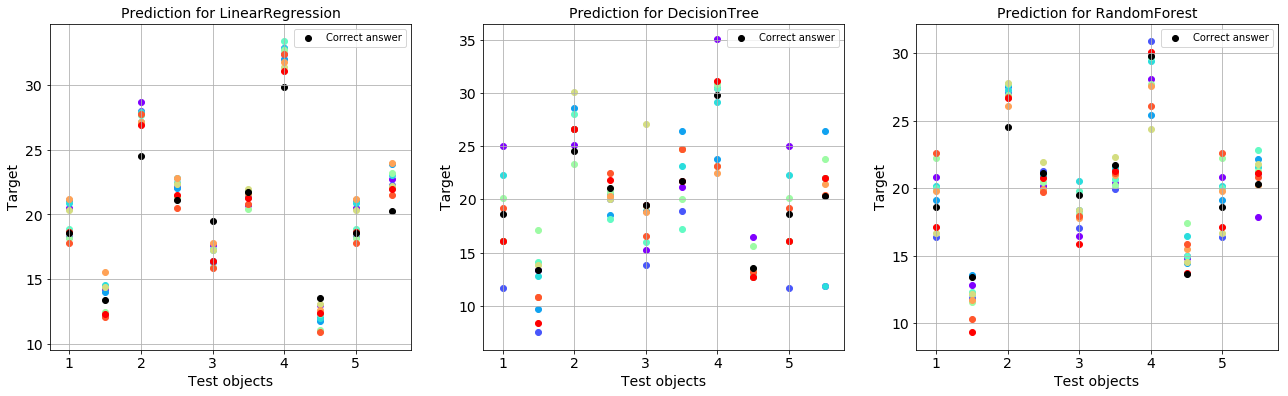

In [621]:
fig, ax = plt.subplots(1, 3, figsize=(22,6))
plot_predictions(linear_model.LinearRegression(), X, y, ax[0], num_runs=100, num_test_objects=10, title='Prediction for LinearRegression');
plot_predictions(tree.DecisionTreeRegressor(), X, y, ax[1], num_runs=100, num_test_objects=10, title='Prediction for DecisionTree');
plot_predictions(ensemble.RandomForestRegressor(), X, y, ax[2], num_runs=100, num_test_objects=10, title='Prediction for RandomForest');



Для каждого графика прокомментируйте, как он характеризует смещение и разброс соответствующего алгоритма. 

__Your answer here:__

Смещение линейной регресии однозначно больше чем у дерева и леса. Однако, разброс даного алгоритма маленький. Чего нельзя сказать о решающем дереве. Разброс ответом очень большой(что, в принципе, ожидаемо). Смещение в свою очередь, меньше.
Случайный лес характеризуется низким смещением и чуть меншим разбросом чем у решающего дерева.Но всеравно больше чем у линейной регресии. Имею смелость предположить что тут недостаточно даных для обучения и нужно настраивать параметры для леса, тогда, скорее всего, мы сможем получить еще меньший разброс.

### Изменение bias и variance при изменении гиперпараметров

__7. (0 баллов)__

Постройте графики зависимости смещения и разброса от гиперпараметров решающего дерева max_depth (от 1 до 10) и max_features (от 1 до X.shape[1]):

In [636]:
import itertools

In [644]:
combines = [(x, y) for x in np.arange(1, 10) for y in np.arange(1,X.shape[1])]

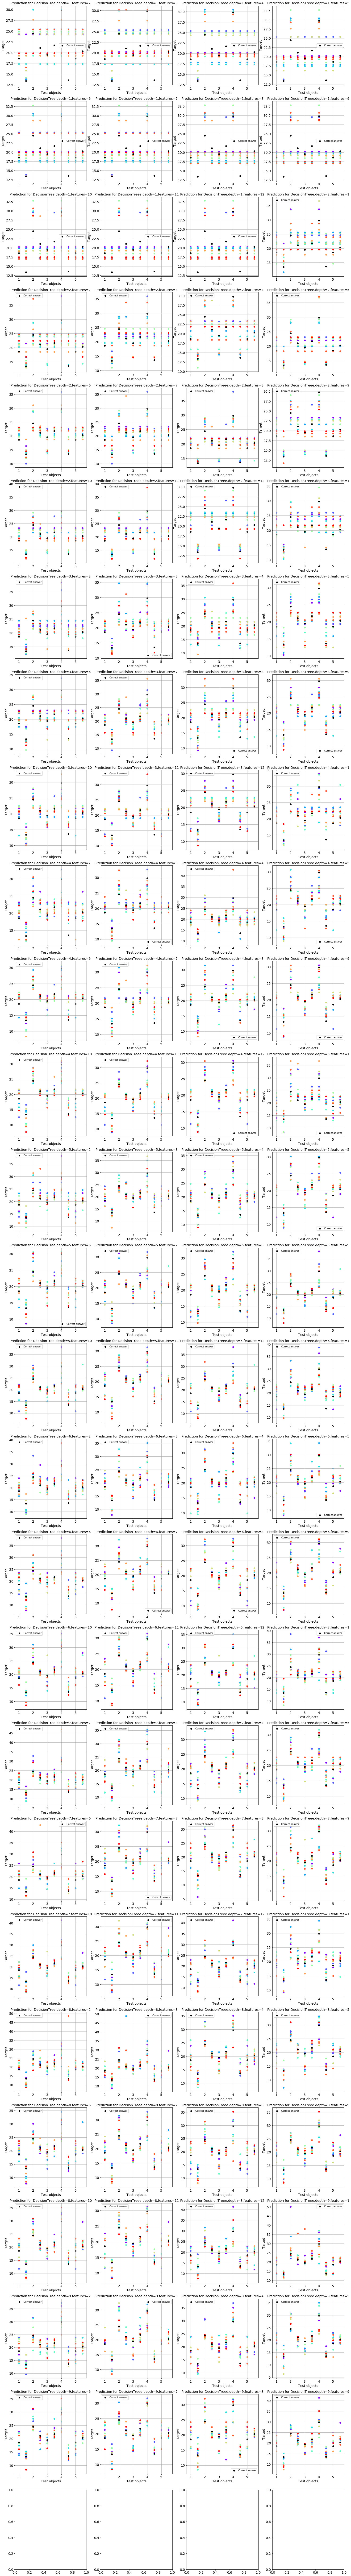

In [648]:
fig, axes = plt.subplots(27, 4, figsize=(25,200))
# for ax, depth in zip(axes, np.arange(1, 10))
#     for feature in np.arange(1, X.shape[1]):

for ax,i in zip(axes, np.arange(4, 108, 4)):
    plot_predictions(tree.DecisionTreeRegressor(max_depth=combines[i-3][0], max_features=combines[i-3][1]), X, y, ax[0], num_runs=100, num_test_objects=10, title='Prediction for DecisionTree.depth={0}.features={1}'.format(combines[i-3][0], combines[i-3][1]));
    plot_predictions(tree.DecisionTreeRegressor(max_depth=combines[i-2][0], max_features=combines[i-2][1]), X, y, ax[1], num_runs=100, num_test_objects=10, title='Prediction for DecisionTreee.depth={0}.features={1}'.format(combines[i-2][0], combines[i-2][1]));
    plot_predictions(tree.DecisionTreeRegressor(max_depth=combines[i-1][0], max_features=combines[i-1][1]), X, y, ax[2], num_runs=100, num_test_objects=10, title='Prediction for DecisionTreee.depth={0}.features={1}'.format(combines[i-1][0], combines[i-1][1]));
    plot_predictions(tree.DecisionTreeRegressor(max_depth=combines[i][0], max_features=combines[i][1]), X, y, ax[3], num_runs=100, num_test_objects=10, title='Prediction for DecisionTreee.depth={0}.features={1}'.format(combines[i][0], combines[i][1]));